# Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_selection import mutual_info_classif

import os
import joblib


# Loading Dataset

In [2]:
ML_df = pd.read_csv("Dataset/ML-EdgeIIOT-dataset-cleaned.csv")

# Exploratory Data Analysis

## Correlation Analysis

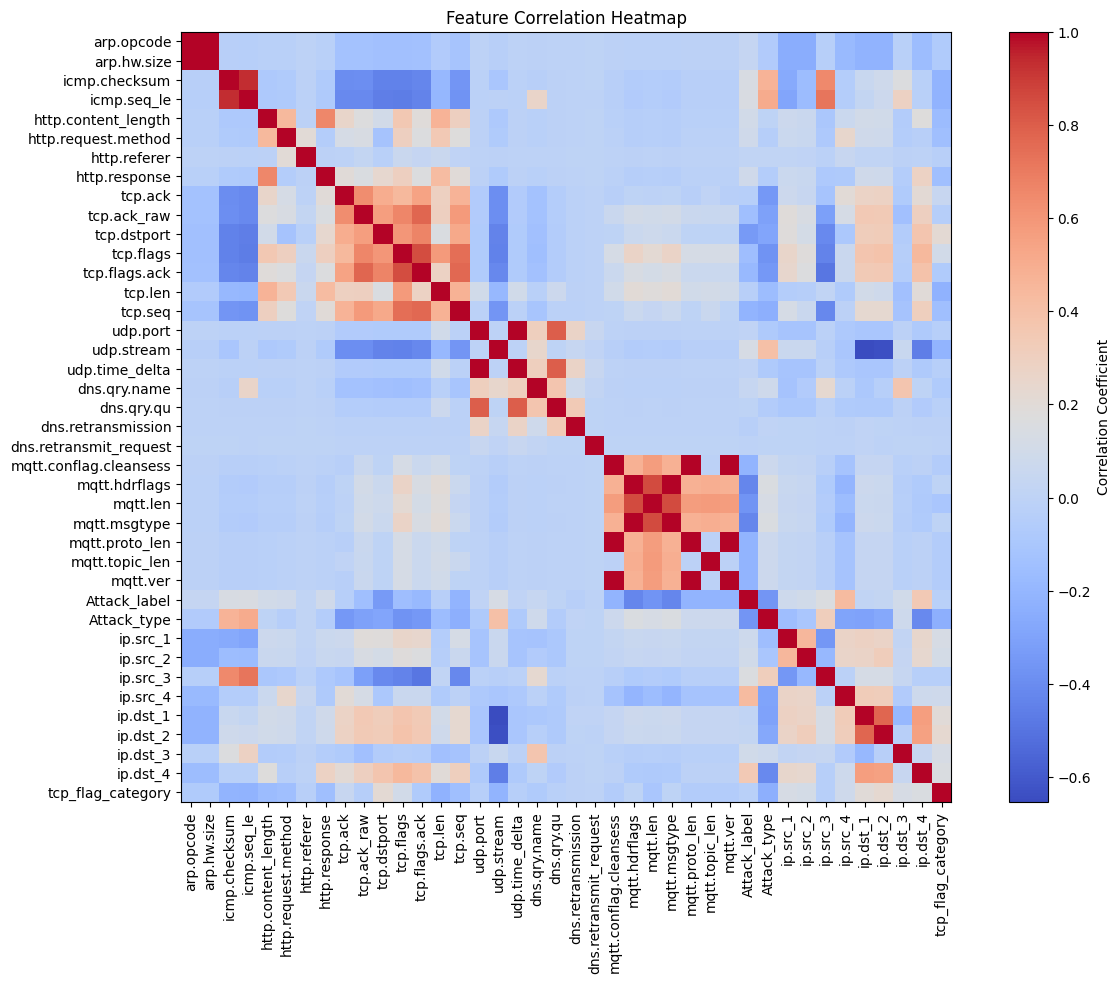

In [3]:
# Compute the correlation matrix using Spearman method
correlation_matrix = ML_df.corr(method='spearman')

# Plot the heatmap using Matplotlib
plt.figure(figsize=(15, 10))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation='nearest')
plt.colorbar(label="Correlation Coefficient")

# Add feature labels
feature_names = correlation_matrix.columns
num_features = len(feature_names)

plt.xticks(ticks=np.arange(num_features), labels=feature_names, rotation=90)
plt.yticks(ticks=np.arange(num_features), labels=feature_names)
plt.title("Feature Correlation Heatmap")
plt.show()

In [4]:
# Define correlation threshold
threshold = 0.85
highly_correlated_pairs = []

# Compute correlation matrix
correlation_matrix = ML_df.corr()

# Identify feature pairs with high correlation
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            highly_correlated_pairs.append((col1, col2, correlation_value))

# Sort by absolute correlation value (descending order)
highly_correlated_pairs = sorted(highly_correlated_pairs, key=lambda x: abs(x[2]), reverse=True)

# Print all highly correlated feature pairs
print("Feature pairs with correlation > 0.85 or < -0.85:")
for pair in highly_correlated_pairs:
    print(f"{pair[0]} ↔ {pair[1]}  |  Correlation: {pair[2]:.2f}")

# List features to remove (second feature in each pair)
highly_correlated_features = set([pair[1] for pair in highly_correlated_pairs])

# Print all features that are marked for removal
print("\nFeatures to be removed (due to high correlation):")
print(highly_correlated_features)

Feature pairs with correlation > 0.85 or < -0.85:
mqtt.msgtype ↔ mqtt.hdrflags  |  Correlation: 1.00
mqtt.proto_len ↔ mqtt.conflag.cleansess  |  Correlation: 1.00
mqtt.ver ↔ mqtt.conflag.cleansess  |  Correlation: 1.00
mqtt.ver ↔ mqtt.proto_len  |  Correlation: 1.00
mqtt.topic_len ↔ mqtt.len  |  Correlation: 0.95
tcp.flags.ack ↔ tcp.flags  |  Correlation: 0.95
arp.hw.size ↔ arp.opcode  |  Correlation: 0.94
ip.dst_2 ↔ ip.dst_1  |  Correlation: 0.91

Features to be removed (due to high correlation):
{'mqtt.len', 'mqtt.proto_len', 'mqtt.conflag.cleansess', 'arp.opcode', 'tcp.flags', 'mqtt.hdrflags', 'ip.dst_1'}


In [5]:
print(len(highly_correlated_features))

7


In [6]:
# remove ip_dst_1 from the highly_correlated_features list
highly_correlated_features.remove('ip.dst_1')
print(len(highly_correlated_features))

6


In [7]:
# Drop highly correlated features from the dataset
ML_df = ML_df.drop(columns=highly_correlated_features)

In [8]:
ML_df.shape

(157800, 34)

In [9]:
# save the datafram to a csv file
ML_df.to_csv('Dataset/ML-EdgeIIOT-dataset-cleaned-2.csv', index=False)

In [10]:
# print the datatype and name of each column
print(ML_df.dtypes)

arp.hw.size                 int64
icmp.checksum             float64
icmp.seq_le               float64
http.content_length       float64
http.request.method         int64
http.referer                int64
http.response               int64
tcp.ack                   float64
tcp.ack_raw               float64
tcp.dstport               float64
tcp.flags.ack               int64
tcp.len                   float64
tcp.seq                   float64
udp.port                  float64
udp.stream                float64
udp.time_delta            float64
dns.qry.name              float64
dns.qry.qu                float64
dns.retransmission          int64
dns.retransmit_request      int64
mqtt.msgtype                int64
mqtt.topic_len              int64
mqtt.ver                    int64
Attack_label                int64
Attack_type                 int64
ip.src_1                    int64
ip.src_2                    int64
ip.src_3                    int64
ip.src_4                    int64
ip.dst_1      

# Preprocessing Methods

## Mutual Information Selection

In [11]:
def preprocess_method_1(df, k=25):
    
    X = df.drop(columns=["Attack_type", "Attack_label"])
    y = df["Attack_type"]

    mi_scores = mutual_info_classif(X, y, discrete_features=False)  
    feature_scores = dict(zip(X.columns, mi_scores))

    # Select top-k features
    top_features = sorted(feature_scores, key=feature_scores.get, reverse=True)[:k]
    X_selected = X[top_features]

    return train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

## Recursive Feature Elimination

In [12]:
def preprocess_method_2(df):
    """Applies RFE, saves the selector, and returns the selected features."""
    
    X = df.drop(columns=["Attack_type", "Attack_label"])
    y = df["Attack_type"]

    model = RandomForestClassifier(n_estimators=50, random_state=42)
    rfe = RFE(model, n_features_to_select=25)  # Select best 25 features
    X_selected = rfe.fit_transform(X, y)

    # Save the trained RFE selector
    joblib.dump(rfe, "Models/rfe_selector.pkl")

    return train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

## Principal Component Analysis

In [13]:
def preprocess_method_3(df):

    X = df.drop(columns=["Attack_type", "Attack_label"])
    y = df["Attack_type"]

    pca = PCA(n_components=25)
    X_pca = pca.fit_transform(X)

    return train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
method_names = {
    preprocess_method_1: "MIS",  # Mutual Information Selection
    preprocess_method_2: "RFE",  # Recursive Feature Elimination
    preprocess_method_3: "PCA"   # Principal Component Analysis
}

# Training ML Model

In [15]:
# def train_ml_models(X_train, y_train, X_test, y_test, method_name):
#     """Train ML models, save them, and return accuracy scores"""
#     models = {
#         "LogisticRegression": LogisticRegression(max_iter=200),
#         "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
#         "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
#         "SVM": SVC(kernel="rbf")
#     }

#     results = {}
#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         acc = accuracy_score(y_test, y_pred)
#         results[name] = acc

#         # Save model with correct nomenclature
#         model_filename = f"Models/{method_name}_{name}.pkl"
#         joblib.dump(model, model_filename)

#     return results

In [16]:
# results_df = pd.DataFrame(columns=["Preprocessing", "Logistic Regression", "Random Forest", "Gradient Boosting", "SVM"])

In [17]:
# for preprocess_fn in [preprocess_method_1, preprocess_method_2, preprocess_method_3]:
#     # Get method name
#     method_name = method_names[preprocess_fn]

#     # Get preprocessed data
#     X_train, X_test, y_train, y_test = preprocess_fn(ML_df)
    
#     # Train ML Models and save them
#     model_results = train_ml_models(X_train, y_train, X_test, y_test, method_name)

#     # Store results
#     results_df.loc[len(results_df)] = [method_name] + list(model_results.values())


In [18]:
# results_df

In [19]:
# # save the results to a CSV file
# results_df.to_csv("ML_Models_Results.csv", index=False)

In [20]:
def train_ml_model(X_train, y_train, X_test, y_test):
    """Train Gradient Boosting model, save it, and return accuracy."""
    
    model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Save only Gradient Boosting Model
    joblib.dump(model, "Models/gradient_boosting.pkl")

    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)


In [21]:
# Load dataset
X_train, X_test, y_train, y_test = preprocess_method_2(ML_df)

# Train and save the model
accuracy = train_ml_model(X_train, y_train, X_test, y_test)
print(f"Gradient Boosting Accuracy (RFE Features): {accuracy:.4f}")

Gradient Boosting Accuracy (RFE Features): 0.9315
